In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.4.1


In [13]:
# 1 导入数据
imdb = keras.datasets.imdb
# 影评数据集。标签0表示消极评论，1表示积极评论。
# 特征是整数值，对应词典中的单词。每一条数据保留多个单词，但是单词的数量不同
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
len(train_data[0]), len(train_data[1])

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Python\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Python\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

(218, 189)

In [14]:
# 通过以下方法将整数转换为其对应的单词
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [15]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [20]:
# 2 数据处理。将文本数据进行标准化，补齐长度
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)
print(len(train_data[0]), len(train_data[1]))
print(train_data[0])

256 256
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  10

In [21]:
# 输入形状是用于电影评论的词汇数目（10,000 词）
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()
# 第一层是嵌入（Embedding）层。该层采用整数编码的词汇表，并查找每个词索引的嵌入向量（embedding vector）。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：(batch, sequence, embedding)。
# 接下来，GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。
# 该定长输出向量通过一个有 16 个隐层单元的全连接（Dense）层传输。
# 最后一层与单个输出结点密集连接。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 3.3损失函数 3.5 优化器 4 评估方法
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [23]:
# 4 制作评估数据
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]


In [24]:
#  3 训练模型。这一次在训练过程中，添加了评估数据，用于计算accuracy
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 31ms/step - loss: 0.6925 - accuracy: 0.5178 - val_loss: 0.6902 - val_accuracy: 0.5984
Epoch 2/40
30/30 [==============================] - 1s 22ms/step - loss: 0.6878 - accuracy: 0.6231 - val_loss: 0.6816 - val_accuracy: 0.7167
Epoch 3/40
30/30 [==============================] - 1s 21ms/step - loss: 0.6764 - accuracy: 0.7254 - val_loss: 0.6651 - val_accuracy: 0.7369
Epoch 4/40
30/30 [==============================] - 1s 23ms/step - loss: 0.6562 - accuracy: 0.7565 - val_loss: 0.6391 - val_accuracy: 0.7447
Epoch 5/40
30/30 [==============================] - 1s 23ms/step - loss: 0.6247 - accuracy: 0.7746 - val_loss: 0.6029 - val_accuracy: 0.7853
Epoch 6/40
30/30 [==============================] - 1s 21ms/step - loss: 0.5819 - accuracy: 0.8060 - val_loss: 0.5615 - val_accuracy: 0.8035
Epoch 7/40
30/30 [==============================] - 1s 23ms/step - loss: 0.5343 - accuracy: 0.8281 - val_loss: 0.5183 - val_accuracy: 0.8224
Epoch 8/40
30

In [26]:
# 4 评估模型
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 0s - loss: 0.3326 - accuracy: 0.8710
[0.33264172077178955, 0.8709999918937683]


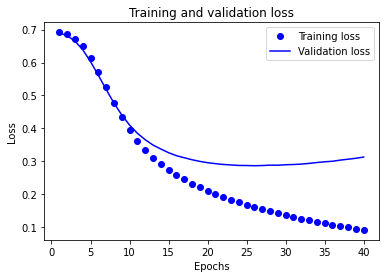

In [29]:
# 4 评估模型，绘制loss和accuracy的曲线图
history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

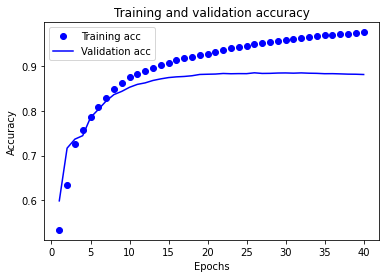

In [30]:
# 绘制loss的曲线
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()